#**Deep Learning Homework 5: *Autoencoders***
## Can Abdullah Camuz
### MSc Computer Science, Data Science, Cybersecurity Computer Engeneering @UniPD
### 2nd semester - 6 ECTS
### Prof. Nicolò Navarin & Prof. Alessandro Sperduti
---


In this homework, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [1]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [2]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 3s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [3]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [4]:
ENCODING_DIM = 120

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [5]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [6]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00372
Test mse: 0.00375


In [7]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

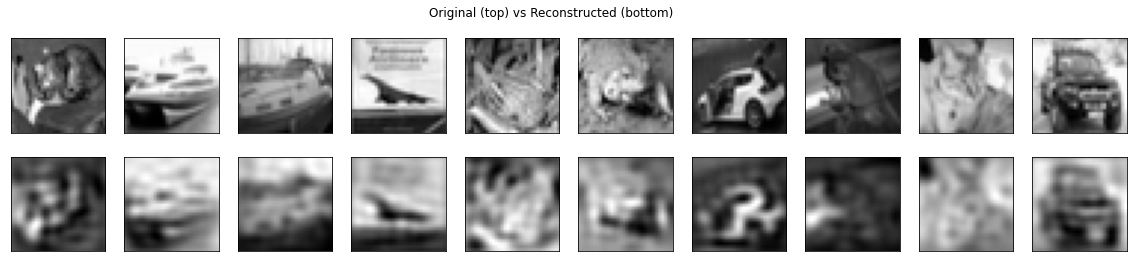

In [8]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_ I will use different `ENCODING_DIM` values and show the effect in the output.

I will observe and discuss the results below.

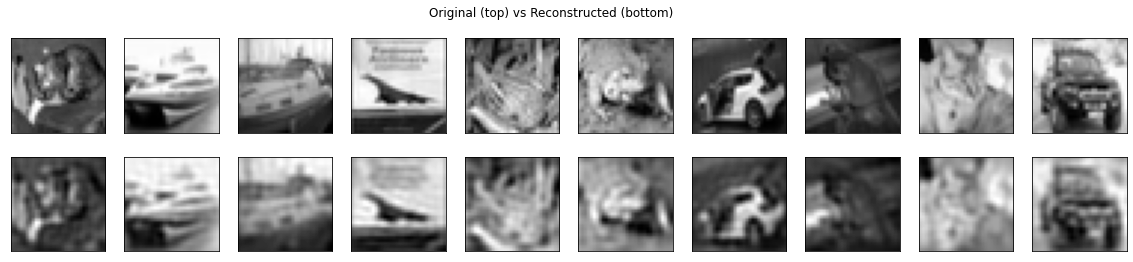

In [15]:
ENCODING_DIM = 240

U_k2 = SVD(x_train, ENCODING_DIM)

x_training_svd2 = np.dot(x_train, U_k2)
x_test_svd2 = np.dot(x_test, U_k2)

x_training_reco2 = np.dot(x_training_svd2, U_k2.T)
x_test_reco2 = np.dot(x_test_svd2, U_k2.T)

plot_img(10, [x_test, x_test_reco2], title = "Original (top) vs Reconstructed (bottom)")

**Obtaining the accuracies in this case 2:**

In [17]:
accuracy_train2 = ((x_train - x_training_reco2)**2).mean()
accuracy_test2 = ((x_test - x_test_reco2)**2).mean()

print("Training mse: %.5f" % ( accuracy_train2))
print("Test mse: %.5f" % ( accuracy_test2))

Training mse: 0.00165
Test mse: 0.00168


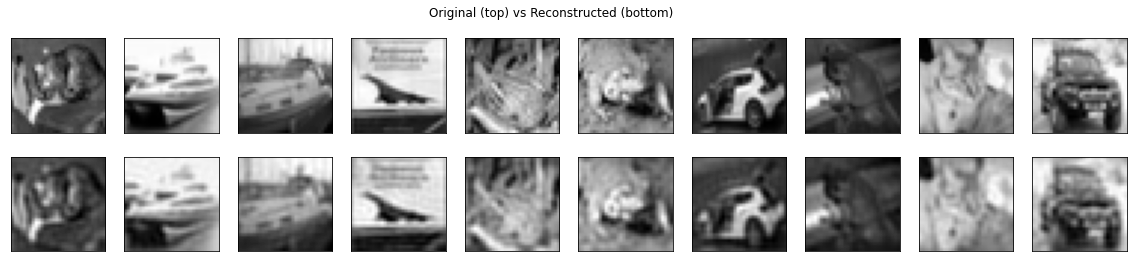

In [16]:
ENCODING_DIM = 360

U_k3 = SVD(x_train, ENCODING_DIM)

x_training_svd3 = np.dot(x_train, U_k3)
x_test_svd3 = np.dot(x_test, U_k3)

x_training_reco3 = np.dot(x_training_svd3, U_k3.T)
x_test_reco3 = np.dot(x_test_svd3, U_k3.T)

plot_img(10, [x_test, x_test_reco3], title = "Original (top) vs Reconstructed (bottom)")

**Obtaining the accuracies in this case 3:**

In [18]:
accuracy_train3 = ((x_train - x_training_reco3)**2).mean()
accuracy_test3 = ((x_test - x_test_reco3)**2).mean()

print("Training mse: %.5f" % ( accuracy_train3))
print("Test mse: %.5f" % ( accuracy_test3))

Training mse: 0.00083
Test mse: 0.00086


It is observed that, when the `ENCODING_DIM` value increases, training and test errors decrease rapidly, and reconstructions get higher accuracy, higher quality. They resemble more to the original images.

This is because when the encoding size increases, the ability to keep the important information (useful properties) of the data will increase. With small encoding dimension, matrices also have small dimensions so the model can only keep a little amount of imformation of the original data. This implies that the required training time is less when there are few dimensions, in terms of matrix operations.

If we reduce the number of dimensions, we are essentially compressing the data more, by having smaller encoder dimension than the input dimension. This is called an "undercomplete encoder" and helps to obtain only useful features in the reconstruction.

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [92]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [93]:
autoencoder.summary()

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_32 (Dense)            (None, 256)               262400    
                                                                 
 dense_33 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [94]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 39ms/step - loss: 0.1965 - val_loss: 0.0311
Epoch 2/15
79/79 [==============================] - 4s 51ms/step - loss: 0.0472 - val_loss: 0.0321
Epoch 3/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0200 - val_loss: 0.0172
Epoch 4/15
79/79 [==============================] - 3s 41ms/step - loss: 0.0156 - val_loss: 0.0144
Epoch 5/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0133 - val_loss: 0.0125
Epoch 6/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0116 - val_loss: 0.0110
Epoch 7/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0103 - val_loss: 0.0100
Epoch 8/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0095 - val_loss: 0.0090
Epoch 9/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0090 - val_loss: 0.0082
Epoch 10/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0079 - val_loss: 0.0086
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [95]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0055 - 884ms/epoch - 3ms/step
Test mse: 0.00553


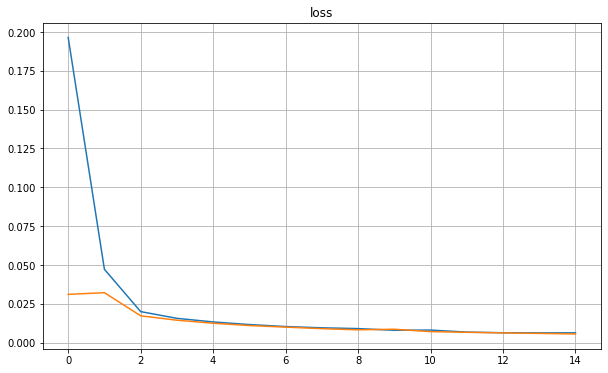

In [96]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

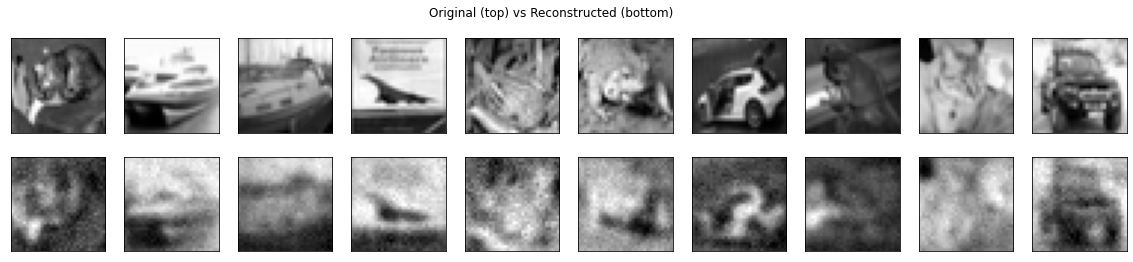

In [98]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


### _Answer:_ 

I tried given shallow encoder with different dimensions and obtained the following results:


Test MSE of **SVD** with encoding dim of **120**: 0.00375

Test MSE of **Shallow Linear Autoencoder** with encoding dim of **256**: 0.00553

Test MSE of **Shallow Linear Autoencoder** with encoding dim of **120**: 0.00633

Test MSE of **Shallow Linear Autoencoder** with encoding dim of **30**: 0.01066


With the same encoding dimension (both 120) SVD has a lower mse value and this mse value tends to decrease when encoding dimension is greater.
Since SVD does analytical decomposition, with a proper dimension, it is able to represent the data thoroughly. On the other hand, shallow linear autoencoder has to learn the features of the data with the encoder, which is not as precise as SVD. 
Also, I noticed that SVD requires less training time since the matrix decomposition is performed faster than the gradient descents in the linear autoencoder model.




##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [80]:
ENCODING_DIM = 256
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [81]:
autoencoder.summary()

Model: "model_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_26 (Dense)            (None, 256)               262400    
                                                                 
 dense_27 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 3s 38ms/step - loss: 0.0358 - val_loss: 0.0261
Epoch 2/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0191 - val_loss: 0.0194
Epoch 3/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0166 - val_loss: 0.0131
Epoch 4/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0135 - val_loss: 0.0080
Epoch 5/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0115 - val_loss: 0.0072
Epoch 6/15
79/79 [==============================] - 3s 36ms/step - loss: 0.0109 - val_loss: 0.0070
Epoch 7/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 8/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 9/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 10/15
79/79 [==============================] - 3s 37ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 11/

313/313 - 1s - loss: 0.0032 - 763ms/epoch - 2ms/step
Test mse: 0.00319


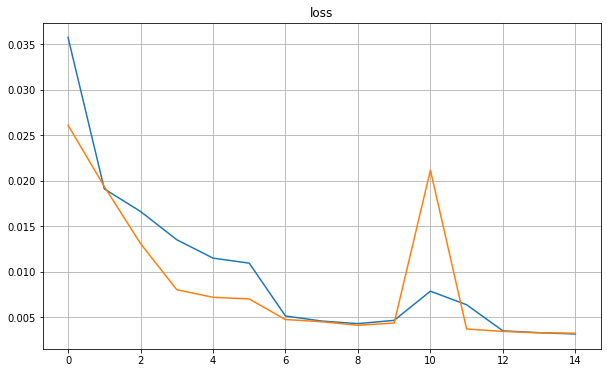

In [83]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

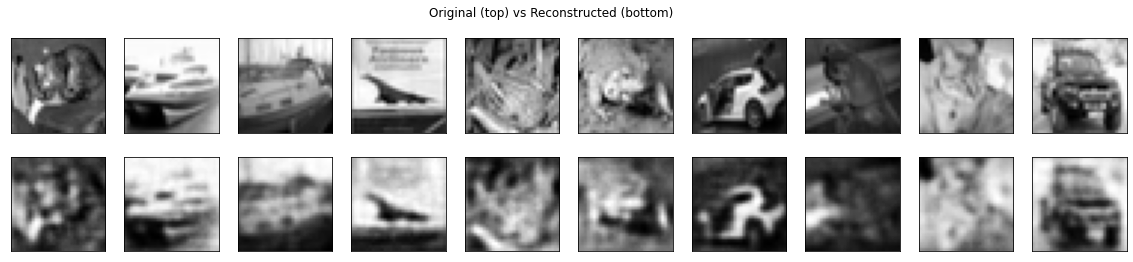

In [85]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

### _Discussion:_ 

Test MSE of Shallow **Linear** Autoencoder with encoding dim of 256: 0.00544

Test MSE of Shallow **Non-Linear** Autoencoder with **sigmoid** input and encoding layer with encoding dim of 256: 0.00662

Test MSE of Shallow **Non-Linear** Autoencoder with **relu** input and encoding layer with encoding dim of 256: 0.03252


Test MSE of Shallow **Non-Linear** Autoencoder with **linear** input layer and **sigmoid** encoding layer with encoding dim of 256: 0.01174


Test MSE of Shallow **Non-Linear** Autoencoder with **sigmoid** input layer and **linear** encoding layer with encoding dim of 256: 0.00319


For this model, I have chosen sigmoid activation function because it is a continuous function that gives in output a value between 0 and 1. Since we want that our output is representative of our input, the input range should be preserved.In this case, sigmoidal function yields the values for the pixels of the output images.

By doing some experiments, I noticed using relu is not suitable for our model because relu function can take positive values up to infinity. This explains why the error is much higher than the model with sigmoid fuction, because relu does not compress the output the values in a finite range. 


I noticed that when the nonlinear activation is used, the MSE value increased and the reconstruction images became more distinct than the orginal ones. The best result in terms of mse is obtained when the activation of input layer is sigmoid and the activation of encoding layer is linear. 

This is because if the encoder and decoder are so complex (allowed too much capacity), the autoencoder may fail without extracting useful information about the data, if the capacity of the autoencoder is allowed to become too great.

##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [99]:
x_train.shape[-1]

1024

In [135]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]

encoded1 = tf.keras.layers.Dense(128, activation='sigmoid')(input_img)
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='tanh')(encoded1)

decoded1 = tf.keras.layers.Dense(128, activation='tanh')(encoded)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded1)


autoencoder = tf.keras.models.Model(input_img, decoded) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [136]:
autoencoder.summary()

Model: "model_61"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_89 (Dense)            (None, 128)               131200    
                                                                 
 dense_90 (Dense)            (None, 64)                8256      
                                                                 
 dense_91 (Dense)            (None, 128)               8320      
                                                                 
 dense_92 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 279,872
Trainable params: 279,872
Non-trainable params: 0
_________________________________________________________________


In [140]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 128, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0103 - val_loss: 0.0101
Epoch 2/15
313/313 [==============================] - 4s 12ms/step - loss: 0.0098 - val_loss: 0.0105
Epoch 3/15
313/313 [==============================] - 4s 12ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 4/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0121
Epoch 5/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 6/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0099 - val_loss: 0.0104
Epoch 7/15
313/313 [==============================] - 4s 12ms/step - loss: 0.0100 - val_loss: 0.0098
Epoch 8/15
313/313 [==============================] - 4s 12ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 9/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0100 - val_loss: 0.0094
Epoch 10/15
313/313 [==============================] - 3s 11ms/step - loss: 0.0110 - val_lo

313/313 - 1s - loss: 0.0096 - 754ms/epoch - 2ms/step
test mse: 0.00958


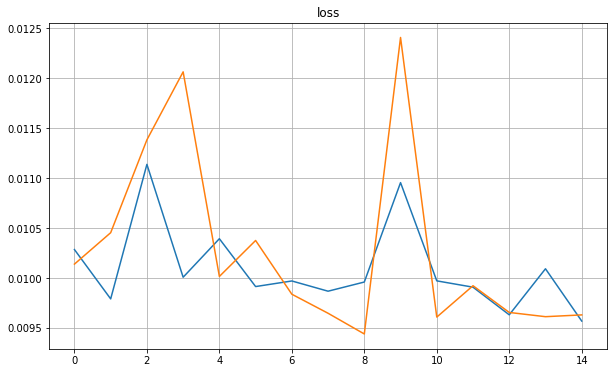

In [141]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

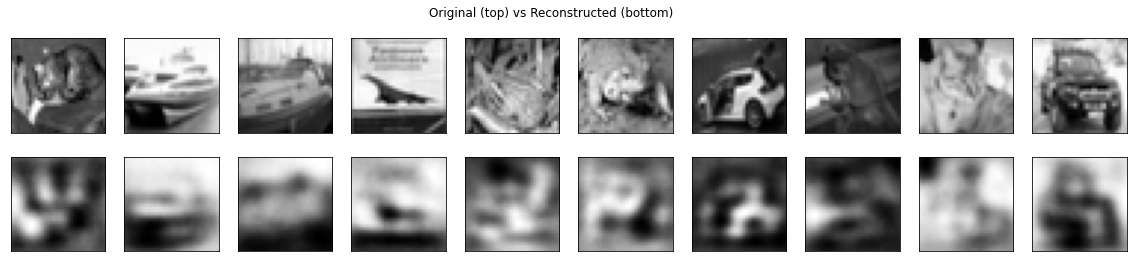

In [142]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [147]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

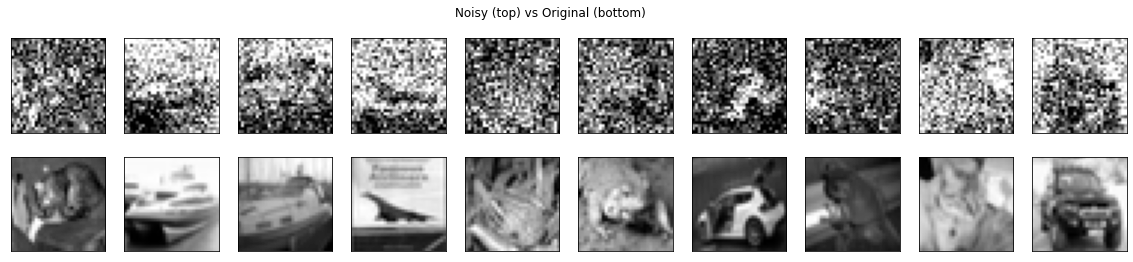

In [148]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [156]:
INPUT_DIM = x_train.shape[-1]

ENCODING_DIM = 256

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='mse') #[TO COMPLETE]

In [157]:
autoencoder.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_48 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_97 (Dense)            (None, 256)               262400    
                                                                 
 dense_98 (Dense)            (None, 1024)              263168    
                                                                 
Total params: 525,568
Trainable params: 525,568
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [158]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=128, shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/15
313/313 [==============================] - 5s 16ms/step - loss: 0.0294 - val_loss: 0.0196
Epoch 2/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0168 - val_loss: 0.0154
Epoch 3/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0145 - val_loss: 0.0141
Epoch 4/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 5/15
313/313 [==============================] - 5s 16ms/step - loss: 0.0126 - val_loss: 0.0125
Epoch 6/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0121 - val_loss: 0.0121
Epoch 7/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 8/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0115 - val_loss: 0.0117
Epoch 9/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 10/15
313/313 [==============================] - 5s 15ms/step - loss: 0.0111 - val_lo

313/313 - 1s - loss: 0.0108 - 1s/epoch - 3ms/step
Test mse: 0.01081


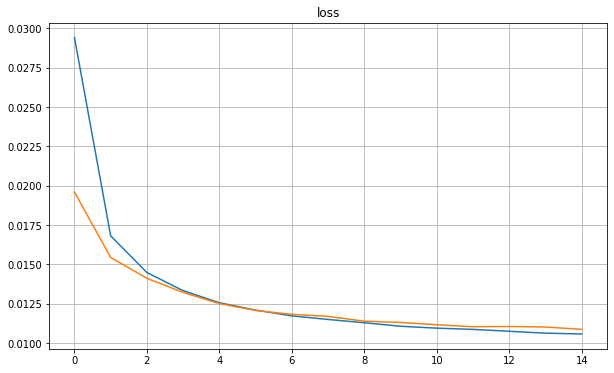

In [159]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

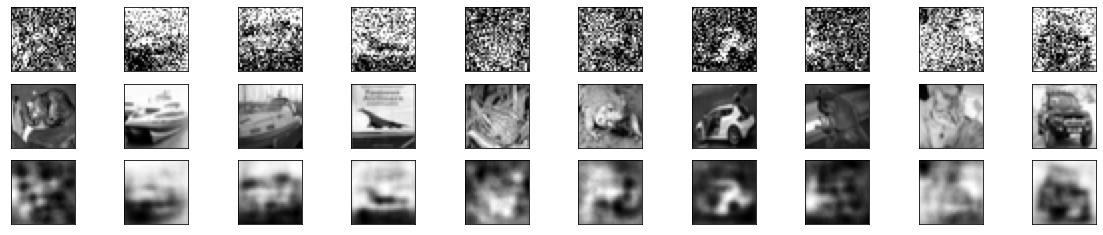

In [160]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [168]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [169]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [170]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_51 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 90, 50)            7550      
                                                                 
 time_distributed_2 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [171]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 89ms/step - loss: 0.1665 - categorical_accuracy: 0.1686 - val_loss: 0.0882 - val_categorical_accuracy: 0.3594
Epoch 2/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0711 - categorical_accuracy: 0.4472 - val_loss: 0.0605 - val_categorical_accuracy: 0.4919
Epoch 3/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0538 - categorical_accuracy: 0.5247 - val_loss: 0.0502 - val_categorical_accuracy: 0.5426
Epoch 4/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0466 - categorical_accuracy: 0.5816 - val_loss: 0.0425 - val_categorical_accuracy: 0.5950
Epoch 5/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0389 - categorical_accuracy: 0.6238 - val_loss: 0.0365 - val_categorical_accuracy: 0.6437
Epoch 6/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0348 - categorical_accuracy: 0.6707 - val_loss: 0.0323 - val_categorical_accuracy: 0.6870
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0099 - categorical_accuracy: 0.9427 - 582ms/epoch - 15ms/step
categorical_accuracy: 94.27%


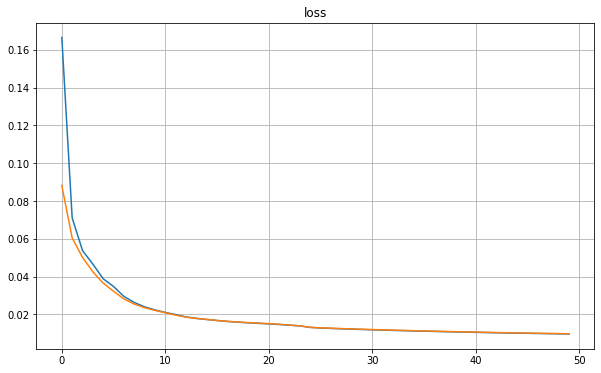

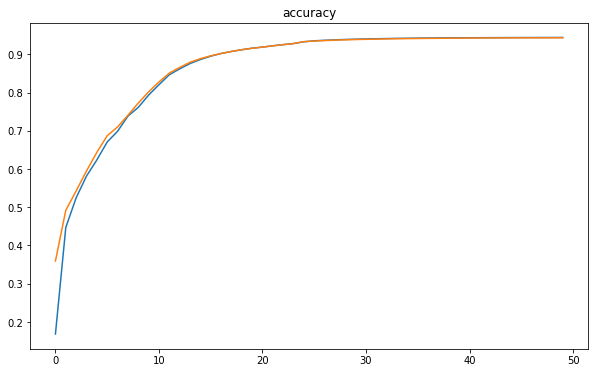

In [172]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [173]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a me <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really movie film that <oov> <oov> <oov> than other <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> or <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [175]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, return_sequences=True, activation='tanh')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_53 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 90, 50)            30200     
                                                                 
 time_distributed_4 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________


In [176]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 15s 165ms/step - loss: 0.0435 - categorical_accuracy: 0.4439 - val_loss: 0.0372 - val_categorical_accuracy: 0.4647
Epoch 2/50
79/79 [==============================] - 12s 157ms/step - loss: 0.0359 - categorical_accuracy: 0.4749 - val_loss: 0.0352 - val_categorical_accuracy: 0.4657
Epoch 3/50
79/79 [==============================] - 12s 153ms/step - loss: 0.0332 - categorical_accuracy: 0.4759 - val_loss: 0.0316 - val_categorical_accuracy: 0.4697
Epoch 4/50
79/79 [==============================] - 12s 154ms/step - loss: 0.0290 - categorical_accuracy: 0.4988 - val_loss: 0.0270 - val_categorical_accuracy: 0.4930
Epoch 5/50
79/79 [==============================] - 12s 152ms/step - loss: 0.0245 - categorical_accuracy: 0.5371 - val_loss: 0.0226 - val_categorical_accuracy: 0.5929
Epoch 6/50
79/79 [==============================] - 12s 154ms/step - loss: 0.0201 - categorical_accuracy: 0.6862 - val_loss: 0.0183 - val_categorical_accuracy: 0.741

40/40 - 1s - loss: 2.6517e-05 - categorical_accuracy: 1.0000 - 832ms/epoch - 21ms/step
categorical_accuracy: 100.00%


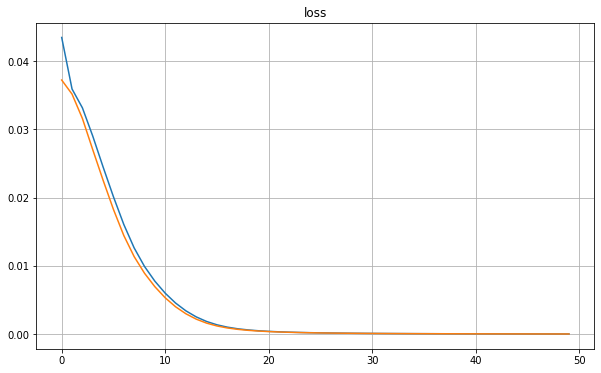

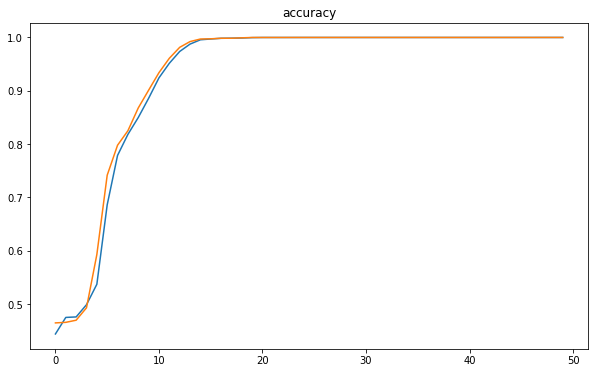

In [177]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

## Results & Discussion

After several experiments, here are the best results I obtained:

Linear Autoencoder: **loss**: 0.0099, **accuracy**: 94.27%;

Non-Linear Autoencoder with **tanh** and **softmax** activation function: **loss**: 0.0069, **accuracy**: 97.35%;

Non-Linear Autoencoder with **tanh** and **sigmoid** activation function: **loss**: 2.6517e-05, **accuracy**: 100%.


**Activation function choice:** We use binary crossentropy loss function for the 0 - 1 problems (binary claasification) for our one hot encoded data. So I was able to use sigmoid and softmax functions in the output (decoder) layer because they both yield values in the range of our input, which is [0,1].

For the LSTM, tanh is a commonly used activation function since it has a better convergence rate than sigmoid and softmax. Also, when the activation function is sigmoidal, it is more prone to face vanishing gradient problem since the network calculates the gradients based on the chain rule. That means the gradient decreases fast. Tanh function copes with this problem better because its derivative is different than sigmoid.

In addition, relu had a poor performance because it is not suitable with our data type, and also not preferred in LSTMs.

So, tanh activation function for hidden layer, and sigmoid for output layer have been selected.

**Comparison of Linear and Non-Linear models:** It is obvious that non-linear models have better performances in terms of accuracy and loss. Thanks to LSTM encoded layer and its nonlinear activation functions, we can have more accurate predictions. Eventhough the activation function selection affects our accuracy a lot in non-linear models, still, these nonlinear activation functions generally outperformed the linear one because nonlinearity allowed the model to learn more complex relationships in the data. This is good for our case since the network is able to reconstruct the sentence with better accuracy.


